# Test and debug Kalman filter

---

## Equations verified by the simulator

$$
\begin{align}
(1+a) m \frac{d^2z_f}{dt^2} = 
- mg
+ mg \frac{\rho_w}{\rho_f}
- m \frac{c_1}{2L} \Big |\frac{dz_f}{dt} - w \Big | \Big ( \frac{dz_f}{dt} - w \Big )
\end{align}
$$

## Equations employed by the Kalman filter

The Kalman state vector is:

$$
\begin{align*}
\underline{x} &= 
\left(\begin{array}{c} 
x_0\\
x_1\\
x_2\\
x_3
\end{array}\right)
=
\left(\begin{array}{c} 
-dz_f/dt\\
-z_f\\
\gamma_e \\
V_e \\
\end{array}\right)
\end{align*}
$$

Variables estimated by the Kalman filter are therefore the depth temporal rate of evolution ($x_0$, in m/s), depth ($x_1$, in m), equivalent compressibility ($\gamma_e$, in m$^2$) and the equivalent volume ($x_3$,  in m$^3$).

The Kalman filter dynamical equation is:

$$
\begin{align}
d\underline{x}/dt &= 
\left(\begin{array}{c} 
dx_0/dt\\
dx_1/dt\\
dx_2/dt\\
dx_3/dt
\end{array}\right)
=
\left(\begin{array}{c} 
-d^2z_f/dt^2\\
-dz_f/dt\\
0\\
0
\end{array}\right)
= 
\left(\begin{array}{c} 
-A (x_3 - x_2 x_1 +v) - B |x_0| x_0 \\
x_0\\
0 \\
0
\end{array}\right), \label{eq:dxdt}
\end{align}
$$

, where several parameters have been introduced: $A = g\rho/2m$ and $B = c_1/4L$.


which dimensionally is equivalent to:

\begin{align}
(1+a) m \frac{d^2z_f}{dt^2} = 
g \rho (V_e + \gamma_e z + v)
- m \frac{c_1}{2L} \Big |\frac{dz_f}{dt} \Big | \Big ( \frac{dz_f}{dt} \Big )
\end{align}

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import interp1d
from copy import deepcopy

import cognac.float as fl

---

## quick note on first order feedback

The control variable is now $v$ instead of $\partial_t v$.

We choose the same relaxation function as for the second order state feedback:

$$
\begin{align}
y = x_0 - \nu \arctan{\frac{\overline{x}_1-x_1}{\delta}}.
\end{align}
$$

We are searching for the command $v$ such that $y$ is the solution of:

$$
\begin{align}
\dot y + \lambda_1 y = 0. \label{eq:f2_y}
\end{align}
$$

For an exponential law of the type $y\sim e^{-r t}$ to be solution of the latter equations, we may choose: $\lambda_1=r$. 
For $r=0.1$~s$^{-1}$: $\lambda_1=0.1$~s$^{-1}$.

Differentiating y with respect to time leads:

$$
\begin{align}
\dot y &= \dot x_0 + \nu \frac{\dot x_1 /\delta}{1+e^2/\delta^2}, \\
&= \dot x_0 + \nu \frac{x_0 /\delta}{D},
\end{align}
$$

where $e=\overline{x_1}-x_1$ and $D=1+e^2/\delta^2$.
Note that time derivatives of $\overline x_1$ are assumed to be small.

From the simplified acceleration equation:

$$
\begin{align}
\dot x_0 &= -A (v + x_3 - x_2 x_1 ) - B |x_0| x_0,
\end{align}
$$

which leads to the following expression for $v$:

$$
\begin{align}
v = -\frac{1}{A} \Big [ 
\dot x_0
+ B |x_0| x_0
\Big ]
-x_3
+x_2 x_1
\end{align}
$$

Plugging in (\ref{eq:f2_y}):

$$
\begin{align}
v &= \frac{1}{A} \Big [ 
\lambda_1 y 
+ \nu \frac{x_0 /\delta}{D}
- B |x_0| x_0
\Big ]
-x_3 + x_2 x_1,
\end{align}
$$

where all terms are estimated with a Kalman filter.


WOA water profile at lon=6, lat=40


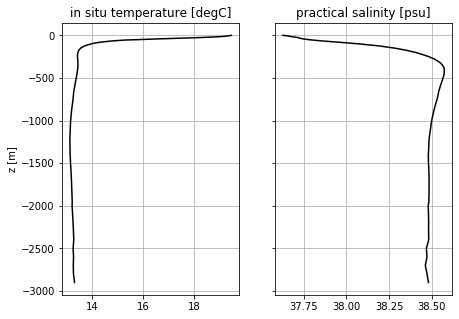

In [2]:
def plot_atan(delta=1, nu=2./np.pi*.1, xlims=None, ylims=None):
    nur = nu*np.pi/2.
    if xlims is None:
        xlims = (-5*delta,5*delta)
    if ylims is None:
        ylims = (-nur*1.5, nur*1.5)
    fig, ax = plt.subplots(1,1)
    x=np.linspace(xlims[0],xlims[1],30)
    ax.plot(x, nu*np.arctan(x/delta), color='orange', lw=3)
    ax.set_xlim(xlims)
    ax.set_ylim(ylims)
    ax.axhline(y=-nur, ls='-.', color='k')
    ax.axhline(y=nur, ls='-.', color='k')
    ax.axvline(x=-delta, ls='--', color='k')
    ax.axvline(x=delta, ls='--', color='k')
    ax.set_xlabel('[m]')
    ax.set_ylabel('[m/s]')
    ax.grid()
plot_atan()

#plt.savefig('feedback_tanh.eps')

--- 
## Instantiate water and float object

In [ ]:
# select a water profile
#w = fl.waterp(lon=-50.,lat=40.) # Gulf Stream
w = fl.waterp(lon=6.,lat=40.) # Mediterranean sea
print(w)

In [3]:
# Init now active control of the vertical position

#
z=np.arange(-500.,0.,1.)
rho_w, p, temp = w.get_rho(z), w.get_p(z), w.get_temp(z)

#
f = fl.autonomous_float(model='Ifremer')
f.init_piston()
print(f)

# adjust mass to be at equilibrium at 0m and substract 5g
iz = np.argmin(np.abs(z+0))
f.adjust_m(p[iz],temp[iz],rho_w[iz], offset=-5)

# compute bounds on motions
fmax, fmin, afmax, wmax = f.compute_bounds(w,-500.)

Piston max volume set from max displacement
Float parameters: 
  L     = 0.83 m      - float length
  r     = 0.07 m      - float radius
  m     = 11.63 kg     - float mass
  V     = 1.27e+04 cm^3   - float volume
  rho_cte = m/V = 9.13e+08 kg.cm^3   - float baseline density
  gamma = 3.78e-06 /dbar  - mechanical compressibility
  gamma x V = 4.82e-02 cm^3/dbar  - normalized compressibility
  alpha = 6.98e-05 /degC  - thermal compressibility
  alpha x V = 8.89e-01 cm^3/degC  - normalized thermal compressibility
  temp0 = 0.00e+00  degC  - reference temperature
  a = 1.00e+00  (no dimension)  - float added mass
  c0 = 0.00e+00  (no dimension)  - float drag parameter 0
  c1 = 1.00e+00  (no dimension)  - float drag parameter 1
Piston parameters and state: 
  r     = 0.97 cm        - piston radius
  d     = 0.00 cm        - present piston displacement
  vol   = 26.88 cm^3      - present volume addition
  d_increment  = 2.14e-02 mm        - smallest variation of translation motion for the p

In [4]:
# adjust piston to be at equilibrium -1m
z0 = -1.
iz = np.argmin(np.abs(z-z0))
vstart = f.set_piston4equilibrium(p[iz],temp[iz],rho_w[iz])
print('z equilibrium = %.1fm' %(f.z4equilibrium(w) ) ) # check

Piston reset for equilibrium : vol=2.2e+01 cm^3  
z equilibrium = -1.0m


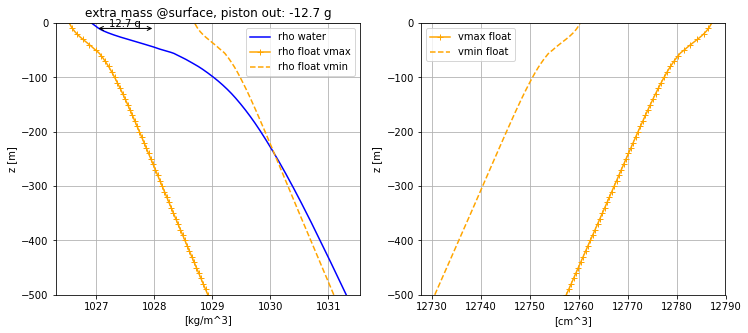

In [5]:
# show densities
fig, ax = plt.subplots(1, 2, figsize=(12,5))
fl.plot_float_density(z, f, w, ax=ax[0])
fl.plot_float_volume(z, f, w, ax=ax[1])

In [6]:
delta_rho = 2 # [kg/m3] change of water density over the depth of interest 
L_rho = 100 # [m] characteristic length scale for water density changes
V_e_rho = -f.V*delta_rho/f.rho_cte # back of the envelope estimate for V_e
acceleration_rho = 0.5*fl.g*delta_rho/f.rho_cte

### equivalent volume and compressibilities

The float dynamics may be simplified and expressed as:

\begin{align}
2m\frac{d^2z_f}{dt^2}
+ m\frac{c_1}{2L} \Big |\frac{dz_f}{dt} \Big | \frac{dz_f}{dt} = 
g \rho (V_e + \gamma_e z + v),
\label{eq:zf_reg3}
\end{align}

where $V_e= V_0 [\delta\rho_w(\overline{z}) - \overline{z} \partial_z \rho_w ]/\rho$, $\gamma_e = V_0 \partial_z \rho_w /\rho + \gamma_V$, and, $\overline{z}$ is the averaged vertical level the float is moving around.


Back of the envelope estimate of V_e: -2.5e+01 cm^3


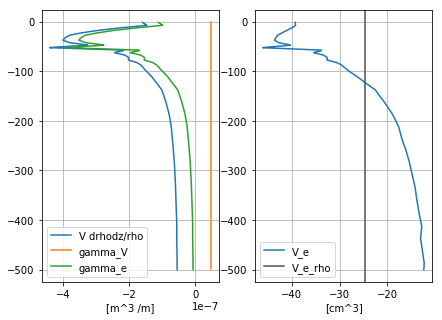

In [7]:
zm = (z[1:]+z[:-1])*.5

V_e = f.V*( (rho_w[:-1]+rho_w[1:])*.5 - f.rho_cte 
           - zm*np.diff(rho_w)/np.diff(z)
          )/f.rho_cte

gamma_V = f.V*f.gamma
gamma_rho = f.V*np.diff(rho_w)/f.rho_cte/np.diff(z)

gamma_e = gamma_rho + gamma_V

V_e100 = interp1d(zm, V_e, kind='linear')(-25)
gamma_e100 = interp1d(zm, gamma_e, kind='linear')(-25)

plt.figure(figsize=(7,5))
ax=plt.subplot(121)
ax.plot(gamma_rho, zm, label='V drhodz/rho')
ax.plot(gamma_V+0.*zm, zm, label='gamma_V')
ax.plot(gamma_e, zm, label='gamma_e')
ax.grid()
ax.legend(loc=3)
ax.set_xlabel('[m^3 /m]')

ax=plt.subplot(122)
ax.plot(V_e*1e6, zm, label='V_e')
ax.axvline(x=V_e_rho*1e6, color='0.3',label='V_e_rho')
ax.grid()
ax.legend()
ax.set_xlabel('[cm^3]')

print('Back of the envelope estimate of V_e: %.1e cm^3' %(V_e_rho*1e6))

---

### set up desired trajectory

In [8]:
# we start by constructing a trajectory that can be followed by the float
target_velocity = 0.05
z_target = fl.descent(3600, -100., wmax=target_velocity, zstart=z0)

Tsim = 2700.

In [9]:
f0 = deepcopy(f)

---

### first order feedback with kalman filter

In [10]:
# kalman parameters
_k = {'dt':.5, 'depth_error': 1e-2}
_k.update({'gamma_e0': -2*f.gammaV, 'V_e0': 0.,
           'gamma':np.array([_k['depth_error']/_k['dt'],
                             _k['depth_error'],
                             f.gammaV,
                             f.V*delta_rho/f.rho_cte,
                            ])**2,
           'gamma_alpha_scaled': np.array([acceleration_rho,
                                           acceleration_rho*_k['dt'],
                                           target_velocity*V_e_rho/L_rho**2,
                                           target_velocity*V_e_rho/L_rho,
                                           ])**2 *1e0})

In [11]:
# control parameters

# note tau is different than for second order

_c = {'mode': 'kalman_feedback1', 'dt': 5., 'dz_nochattering': 0.,
      'nu': 2*target_velocity*2./np.pi, 'tau': 20., 'delta': .1,
      'continuous': False}

Kalman filter: 
  dt     = 0.50 s     - filter time step
  x_hat   = [-0.00e+00,1.00e+00,-9.63e-08,0.00e+00] - kalman state 
  sqrt(diag(gamma)): [2.00e-02 1.00e-02 4.82e-08 2.47e-05]
  sqrt(gamma_alpha) / dt: [9.52e-03 4.76e-03 1.24e-10 1.24e-08]
  sqrt(gamma_beta): [1.00e-02]
Control parameters: 
  mode = kalman_feedback1 
  dt = 5.00e+00 
  dz_nochattering = 0.00e+00 
  tau = 2.00e+01 
  nu = 6.37e-02 
  delta = 1.00e-01 
  continuous = 0.00e+00 

Start time stepping for 45 min ...
... time stepping done


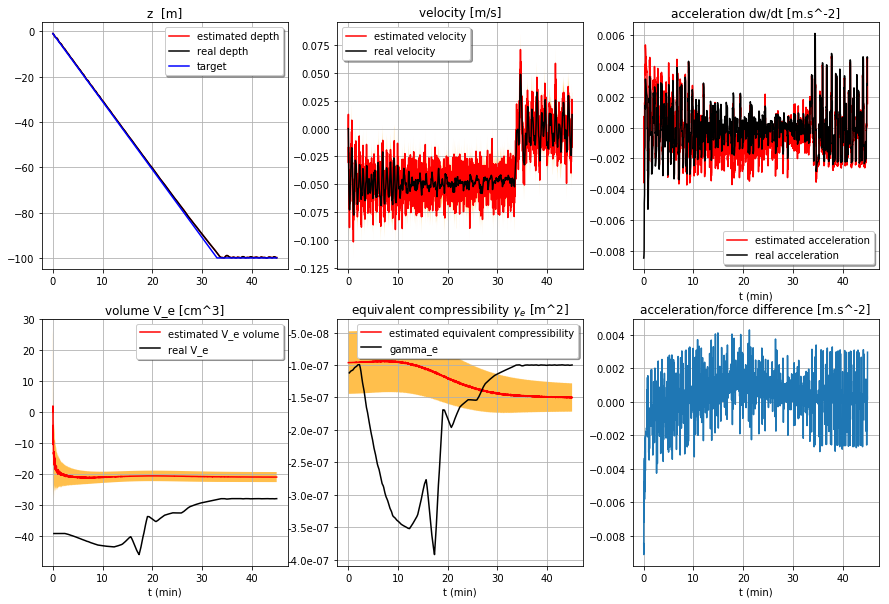

In [12]:
f.time_step(w,T=Tsim, dt_step=.1, dt_log=1., z=z0, w=0., v=f.piston.vol_min,
            piston=True, z_target=z_target, ctrl=_c, kalman=_k, verbose=0)

V_e_z = interp1d(zm, V_e, kind='linear', bounds_error=False)(f.log['state']['z'].values)
gamma_e_z = interp1d(zm, gamma_e, kind='linear', bounds_error=False)(f.log['state']['z'].values)
fl.plot_kalman(f.log, f, V_e = V_e_z, gamma_e = gamma_e_z, z_target=z_target)

Extrapolated energy conssumption: 1.5e-01 Wh/day = 4.6 Wh/30day


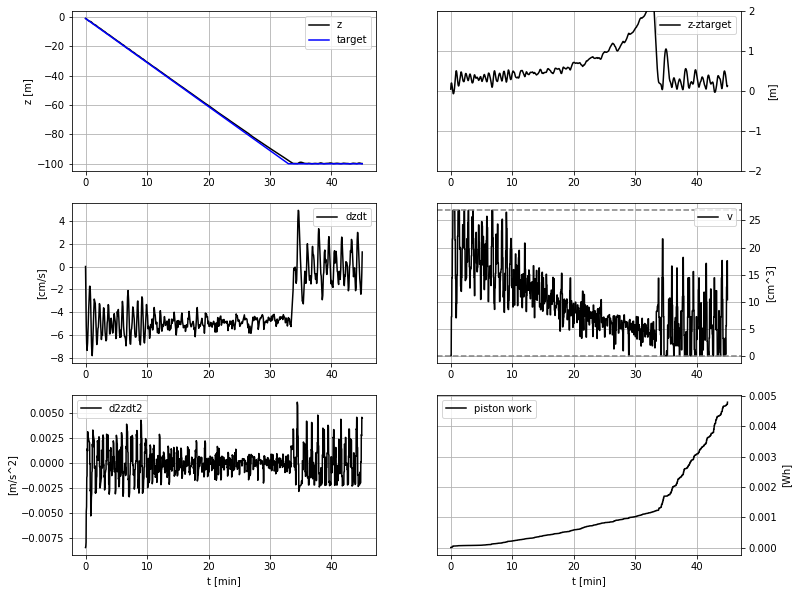

In [13]:
f.plot_logs(z_target=z_target)

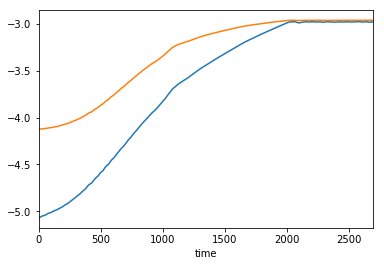

In [14]:
#f.log['state'][['w_rho','w_temp']].plot(subplots=True)
(f.log['state']['w_rho']-1032).plot()
(-f.log['state']['w_temp']*w.get_alpha(-100)*1000).plot()

## look at float resonance

Text(0.5, 0, '[min]')

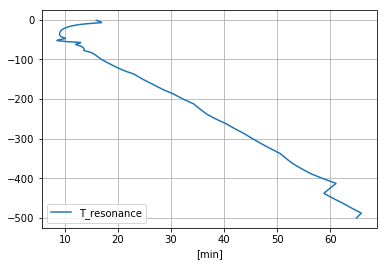

In [15]:
A = f.kalman.A_coeff
T_resonance = 2.*np.pi/np.sqrt(-A*gamma_e)

#plt.figure(figsize=(7,5))
ax=plt.subplot(111)
ax.plot(T_resonance/60., zm, label='T_resonance')
ax.grid()
ax.legend(loc=3)
ax.set_xlabel('[min]')

In [ ]:
f.time_step(w,T=Tsim, dt_step=.1, dt_log=1., z=z0, w=0., #v=f.piston.vol_min,
            piston=True, z_target=z_target, ctrl=None, kalman=None, verbose=0)

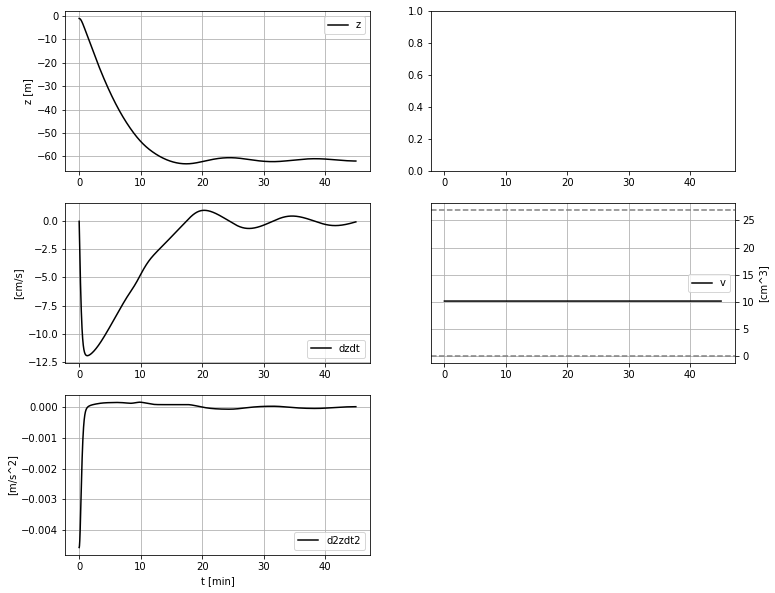

In [19]:
f.plot_logs()

---
## equilibrium depth mapping

In [20]:
z = np.arange(-200.,0.,10.)
rho_w, p, temp = w.get_rho(z), w.get_p(z), w.get_temp(z)
v = np.array([f.volume4equilibrium(p, t, rho) for p, t, rho in zip(p, temp, rho_w)])

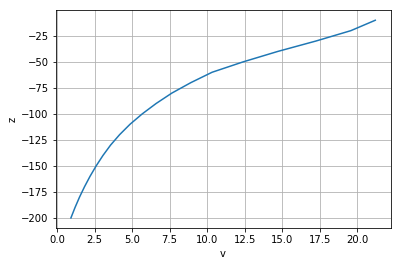

In [27]:
ax = plt.subplot(111)
ax.plot(v*1e6,z)
ax.set_xlabel('v')
ax.set_ylabel('z')
ax.grid()